# Pricing Model

In this notebook, we will try to create a model which is able to predict the price of a house, given a set of features (beds, bath, sqftage).

In [1]:
import numpy as np
import pandas as pd

## Pulling the data from PostgreSQL

In [263]:
import psycopg2

conn = psycopg2.connect(database = "market_analysis", user = "postgres", password = "", host = "127.0.0.1", port = "5432")
print("Opened database successfully")

cur = conn.cursor()

cur.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'real_estate_listings'")
columns = list(map(lambda x: x[0], cur.fetchall()))
columns_str = ', '.join(columns)
cur.execute(f"SELECT {columns_str} from real_estate_listings")
size_limit = 20000
listings = pd.DataFrame(cur.fetchmany(size_limit), columns=columns)

conn.close()
listings

Opened database successfully


,id,price,beds,baths,squarefootage,listeddate,url,address,images,propertytype,attrs
0,1,45000000,2.0,2.0,1344.0,2022-06-10,https://www.zillow.com/homedetails/4375-Cascad...,"4375 Cascade Way, Heritage Ranch, CA 93446",[],MANUFACTURED,{}
1,2,63000000,3.0,2.0,1265.0,2022-06-09,https://www.zillow.com/homedetails/4545-Yerba-...,"4545 Yerba Ave, Atascadero, CA 93422",[],LAND,{}
2,3,270000000,5.0,4.0,3138.0,2022-06-10,https://www.zillow.com/homedetails/4015-Almond...,"4015 Almond Dr, Templeton, CA 93465",[],LAND,{}
3,4,75900000,3.0,2.0,958.0,2022-04-27,https://www.zillow.com/homedetails/1925-Sandow...,"1925 Sandown Pl, Cambria, CA 93428",[],LAND,{}
4,5,130000000,4.0,3.0,2631.0,2022-06-10,https://www.zillow.com/homedetails/545-Maple-S...,"545 Maple St, Paso Robles, CA 93446",[],LAND,{}
...,...,...,...,...,...,...,...,...,...,...,...
3222,3223,36000000,1.0,1.0,728.0,2022-03-21,https://www.zillow.com/homedetails/49-Ice-Hous...,"49 Ice House Cyn, Mt Baldy, CA 91759",[],LAND,{facts=Facts and features\nSingle family resid...
3223,3224,48000000,3.0,2.0,1900.0,2022-06-04,https://www.zillow.com/homedetails/1686-Blackb...,"1686 Blackbird Rd, Wrightwood, CA 92397",[],HOUSE,{facts=Facts and features\nSingle family resid...
3224,3225,53900000,3.0,2.0,2160.0,2022-05-13,https://www.zillow.com/homedetails/5230-Lone-P...,"5230 Lone Pine Canyon Rd, Wrightwood, CA 92397",[],HOUSE,{facts=Facts and features\nSingle family resid...
3225,3226,52000000,3.0,3.0,1816.0,2022-02-02,https://www.zillow.com/homedetails/1793-Sparro...,"1793 Sparrow Rd, Wrightwood, CA 92397",[],HOUSE,{facts=Facts and features\nSingle family resid...


## Data Exploration & Cleaning

1214 samples


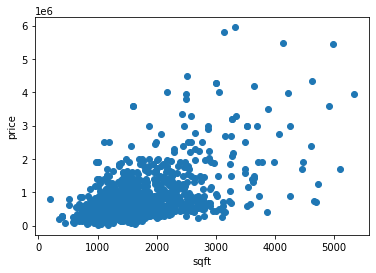

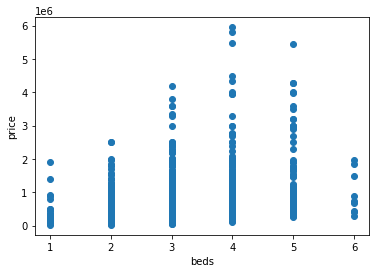

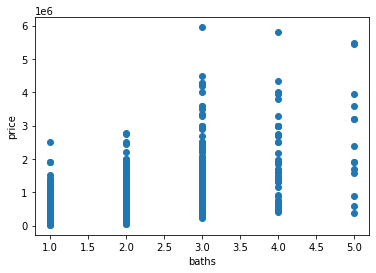

In [264]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
 
# Transform data into format for sklearn
features = ["beds", "baths", "squarefootage"]
pred = "price"
houses = listings[listings["propertytype"] == "HOUSE"][features + ["url", pred]].dropna()

X = np.array(houses[features], dtype=np.float64)
y = np.array(houses[pred], dtype=np.float64) / 100

# Remove outliers
X_outliers_mask = (np.abs(stats.zscore(X)) < 3).all(axis=1)
y_outliers_mask = (np.abs(stats.zscore(y)) < 3)
outliers_mask = X_outliers_mask & y_outliers_mask
X = X[outliers_mask]
y = y[outliers_mask]

print(f'{len(X)} samples')

# Plot the data
plt.xlabel("sqft")
plt.ylabel("price")
plt.scatter(X[:, 2], y)
plt.show()

plt.xlabel("beds")
plt.ylabel("price")
plt.scatter(X[:, 0], y)
plt.show()

plt.xlabel("baths")
plt.ylabel("price")
plt.scatter(X[:, 1], y)
plt.show()

def clean_data(data):
    X = np.array(data[features], dtype=np.float64)
    y = np.array(data[pred], dtype=np.float64) / 100

    # Remove outliers
    X_outliers_mask = (np.abs(stats.zscore(X)) < 3).all(axis=1)
    y_outliers_mask = (np.abs(stats.zscore(y)) < 3)
    outliers_mask = X_outliers_mask & y_outliers_mask
    X = X[outliers_mask]
    y = y[outliers_mask]

    # Normalize features to 0..1
    X_scaler = MinMaxScaler()
    X = X_scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y.reshape(-1, 1))[:, 0]

    # Split into train, test
    return train_test_split(X, y, test_size=0.33)

X_train, X_test, y_train, y_test = clean_data(houses)

## Attemping prediction using sklearn models

MSE Loss: 0.012948480326845117
mean --- y_test: 0.13335406717686216, y_predicted: 0.1517241638901264
Std dev --- y_test: 0.1288906219905649, y_predicted: 0.04520375326473124
[820360.71830643 912287.45335154]


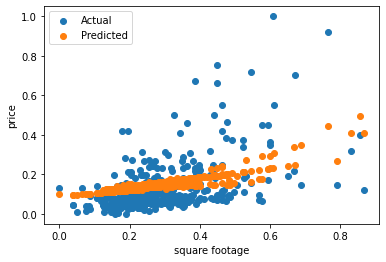

In [269]:
from sklearn import svm

# Create support vector machine regression model, train, predict.
clf = svm.SVR(kernel='rbf', gamma=1)
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test).astype(np.float64)

# Compute loss
mse_loss = np.mean(np.square(y_predicted - y_test))
print(f"MSE Loss: {mse_loss}")
# Compute mean
print(f'mean --- y_test: {np.mean(y_test)}, y_predicted: {np.mean(y_predicted)}')
# Compute std dev
print(f'Std dev --- y_test: {np.std(y_test)}, y_predicted: {np.std(y_predicted)}')

# Test with some made up data
print(y_scaler.inverse_transform(clf.predict(X_scaler.transform([[2, 2, 1000], [3, 2, 2000]])).reshape((-1, 1)))[:, 0])

plt.scatter(X_test[:, 2], y_test, label="Actual")
plt.scatter(X_test[:, 2], y_predicted, label="Predicted")
plt.xlabel("square footage")
plt.ylabel("price")
plt.legend()
plt.show()

SVR model is yielding a densely clustered set of results, as indicated by its stddev and mean. The values seem reasonable.

MSE Loss: 0.01226483189255812
mean --- y_test: 0.13335406717686216, y_predicted: 0.13104389165759117
Std dev -- y_test: 0.1288906219905649, y_predicted: 0.05670416929793003
[603951.63018169 875501.18392361]


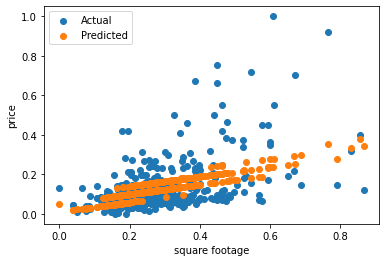

In [270]:
from sklearn.linear_model import SGDRegressor

# Create stochastic gradient descent model, train, predict.
sgd = SGDRegressor(max_iter=1000000, tol=1e-8, alpha=0.0001)
sgd.fit(X_train, y_train)
y_predicted = sgd.predict(X_test).astype(np.float64)

# Compute loss
mse_loss = np.mean(np.square(y_predicted - y_test))
print(f"MSE Loss: {mse_loss}")
# Compute mean
print(f'mean --- y_test: {np.mean(y_test)}, y_predicted: {np.mean(y_predicted)}')
# Compute std dev
print(f'Std dev -- y_test: {np.std(y_test)}, y_predicted: {np.std(y_predicted)}')

# Test with some made up data
print(y_scaler.inverse_transform(sgd.predict(X_scaler.transform([[2, 2, 1000], [3, 2, 2000]])).reshape((-1, 1)))[:, 0])

plt.scatter(X_test[:, 2], y_test, label="Actual")
plt.scatter(X_test[:, 2], y_predicted, label="Predicted")
plt.xlabel("square footage")
plt.ylabel("price")
plt.legend()
plt.show()

MSE Loss: 0.018010020141476287
mean --- y_test: 0.13335406717686216, y_predicted: 0.12279899140194946
Std dev -- y_test: 0.1288906219905649, y_predicted: 0.11005965968649596
[407692.30769231 349038.46153846]


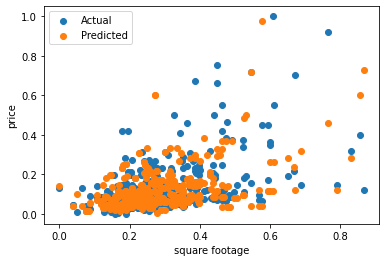

In [271]:
from sklearn.tree import DecisionTreeRegressor

# Create stochastic gradient descent model, train, predict.
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_predicted = dtr.predict(X_test).astype(np.float64)

# Compute loss
mse_loss = np.mean(np.square(y_predicted - y_test))
print(f"MSE Loss: {mse_loss}")
# Compute mean
print(f'mean --- y_test: {np.mean(y_test)}, y_predicted: {np.mean(y_predicted)}')
# Compute std dev
print(f'Std dev -- y_test: {np.std(y_test)}, y_predicted: {np.std(y_predicted)}')

# Test with some made up data
print(y_scaler.inverse_transform(dtr.predict(X_scaler.transform([[2, 2, 1000], [3, 2, 2000]])).reshape((-1, 1)))[:, 0])

plt.scatter(X_test[:, 2], y_test, label="Actual")
plt.scatter(X_test[:, 2], y_predicted, label="Predicted")
plt.xlabel("square footage")
plt.ylabel("price")
plt.legend()
plt.show()

MSE Loss: 0.012166880794342947
mean --- y_test: 0.13335406717686216, y_predicted: 0.13494335439517371
Std dev -- y_test: 0.1288906219905649, y_predicted: 0.0619013435473975
[607081.9253036  713838.20948164]


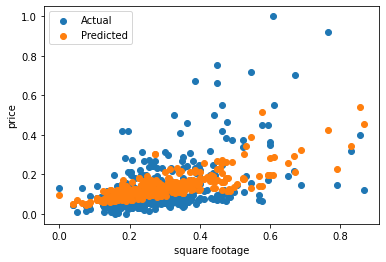

In [272]:
from sklearn.ensemble import VotingRegressor

# Create stochastic gradient descent model, train, predict.
vote = VotingRegressor(estimators=[('dt', dtr), ('sgd', sgd), ('svm', clf)])
vote.fit(X_train, y_train)
y_predicted = vote.predict(X_test).astype(np.float64)

# Compute loss
mse_loss = np.mean(np.square(y_predicted - y_test))
print(f"MSE Loss: {mse_loss}")
# Compute mean
print(f'mean --- y_test: {np.mean(y_test)}, y_predicted: {np.mean(y_predicted)}')
# Compute std dev
print(f'Std dev -- y_test: {np.std(y_test)}, y_predicted: {np.std(y_predicted)}')

# Test with some made up data
print(y_scaler.inverse_transform(vote.predict(X_scaler.transform([[2, 2, 1000], [3, 2, 2000]])).reshape((-1, 1)))[:, 0])

plt.scatter(X_test[:, 2], y_test, label="Actual")
plt.scatter(X_test[:, 2], y_predicted, label="Predicted")
plt.xlabel("square footage")
plt.ylabel("price")
plt.legend()
plt.show()

### Results

Price predictions using stochastic gradient descent, decision trees, and SVM have comparable accuracy. Results are reasonably accurate in most cases, though more features are needed to account for regional differences in price. Using a final voting regressor to average results slightly reduced total loss. Along with a regional ranking value (or average price for the region, some sort of baseline), results could be useful enough to aid decision making.

## PyTorch Model

In [151]:
import torch
from torch import Tensor
from torch.autograd import Variable

class SimpleNet(torch.nn.Module):
   def __init__(self, n_features, n_outputs):
       super(SimpleNet, self).__init__()
       self.layer = torch.nn.Linear(n_features, n_outputs)

   def forward(self, x):
       x = self.layer(x)      
       return x

# Initialize, set up loss & optimizer
net = SimpleNet(len(features), 1)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 1e-8, momentum=0.9)

# Train
inputs = Variable(torch.from_numpy(X_train.astype(np.float32)))
outputs = Variable(torch.from_numpy(y_train.astype(np.float32)))
for i in range(10000):
    prediction = net(inputs)
    loss = loss_func(prediction, outputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
# Test
with torch.no_grad():
    out = net(torch.from_numpy(X_test.astype(np.float32)))
    loss = loss_func(out, torch.from_numpy(y_test.astype(np.float32)))
    print(loss)

plt.show()

tensor(0.0910)


### Result

Not great - this function is simply too linear and has too few features to warrant a network, even this simple network.